# Graph-Rewriting Automata
---

## Required packages

In [334]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import igraph as ig

## Graphs

In Graph-Rewriting Automata, graphs are described by an adjacency matrix $\mathcal{A}$ and a state vector $\mathcal{S}$.
$$G = \{\mathcal{A}, \mathcal{S}\}$$

The `Graph` class has the atributes:
* `adjacency_matrix` ( an instance of the tf.sparse.SparseTensor class )
* `state_vector` ( an instance of the tf.Tensor class )

And the methods:
* `.to_mathematica()`: returns a string corresponding to a Mathematica compatible version of the graph.
* `.order()`: returns the order of the graph
* `.plot()`: plots the graph
* `.evolve(rule)`: evolves the graph according the `rule`

It can be instantiated with:
 * an adjacency matrix that can be either a python nested array or a tensorflow sparse tensor.
 * a state vector that can eiher be a python nested array or a tensorflow tensor.

In [336]:
class Graph:
   
   def __init__(self, adjacency_matrix, state_vector):
        # checks the format of the inputs and acts accordingly to create two properly formated attributes.
        if tf.is_tensor(adjacency_matrix): # if adjacency_matrix is a tensor
            self.adjacency_matrix = adjacency_matrix
        else: # if adjacency_matrix is not a tensor
            self.adjacency_matrix = tf.sparse.from_dense(tf.constant(adjacency_matrix, dtype=tf.int32))
        if tf.is_tensor(state_vector): # if state_vector is a tensor
            self.state_vector = state_vector
        else: # if state_vector is not a tensor
            self.state_vector = tf.constant(state_vector, dtype=tf.int32)

    def to_mathematica(self):
        aM = "SparseArray[{"+','.join([str(list(d))+"->1" for d in self.adjacency_matrix.indices.numpy()+1]).replace('[','{').replace(']','}')+"},{"+','.join([str(d) for d in self.adjacency_matrix.dense_shape.numpy()])+"}]"
        sV = "{"+','.join([str(d) for d in self.state_vector.numpy()]).replace('[','{').replace(']','}')+"}"
        return "{"+aM+","+sV+"}"

    def order(self):
        return self.adjacency_matrix.dense_shape.numpy()[1]

    def plot(self):
        edgelist = np.asarray([list(d) for d in self.adjacency_matrix.indices.numpy()], dtype= np.int32) # TO SIMPLIFY LATER
        g = ig.Graph(n=self.order(), edges=edgelist).simplify()
        visual_style = {}
        visual_style["vertex_size"] = 4
        visual_style["layout"] = g.layout_kamada_kawai(maxiter=10*self.order())
        visual_style["vertex_color"] = ["purple" if self.state_vector.numpy()[d][0]==1 else "orange" for d in range(self.order())]
        return ig.plot(g, **visual_style)
    
    def evolve(self, rule):
        new = rule.evolve(self)
        self.adjacency_matrix = new.adjacency_matrix
        self.state_vector = new.state_vector

#### Example

In [372]:
Graph([ # adjacency matrix
        [0, 1, 1, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 1, 1, 0] 
    ],[ # state vector
        [1],
        [0],
        [0],
        [0] 
    ]);

## Regular Rules

Regular rules specify for each local configuration the future state of the vertex as well as if it must divide.

In [359]:
class RegularRule:
    """
    The RegularRule class can be instantiated with:
     * the degree of the d-regular graph it must be applied to
     * a rule number
    """

    def __init__(self, degree, number):
        if 0 <= int(number) < 4**(2*(int(degree)+1)):
            self.degree = int(degree)
            self.number = int(number)
        else:
            raise TypeError('Invalid input.')
            

    def jump(self, graph, n):
        for i in range(n):
            graph = self.evolve(graph)
        return graph

    def evolve(self, graph):
        adjacency_matrix = graph.adjacency_matrix
        state_vector = graph.state_vector

        # checks the compatibility of the graph
        if not tf.math.reduce_all(tf.equal(tf.sparse.sparse_dense_matmul(adjacency_matrix, tf.transpose([tf.ones(graph.order(), dtype=tf.int32)])),self.degree*tf.transpose([tf.ones(graph.order(), dtype=tf.int32)]))):
            raise TypeError('The provided graph is not a ' + str(self.degree) + '-regular graph, the rule cannot be applied.')

        # computes the configuration vector
        configurations = tf.sparse.sparse_dense_matmul(adjacency_matrix, state_vector).numpy().transpose().squeeze() + 4*state_vector.numpy().transpose().squeeze()

        # creates a list with the 4*(d+1) first binary digits of the rule number
        rule = [int(x) for x in np.binary_repr(self.number)]
        rule.reverse()
        for i in range(len(rule), 4*(self.degree+1)): rule.append(0)

        # computes an updated state vector and a division vector
        new_state_vector = [rule[c] for c in configurations]
        division_vector =  [rule[c+2*(self.degree+1)] for c in configurations]

        while 1 in division_vector:
            i = division_vector.index(1)
            dim = len(division_vector)

            # updates the state vector
            for j in range(self.degree-1):
                new_state_vector.insert(i, new_state_vector[i])

            # updates the division vector
            division_vector[i]=0
            for j in range(self.degree-1):
                division_vector.insert(i, 0)

            # updates the adjacency matrix
            line_indices = tf.sparse.slice(adjacency_matrix, [i,0], [1,dim]).indices.numpy()[:,1]
            new_lines = tf.SparseTensor(indices=[[0,line_indices[0]]], values=[1], dense_shape=[self.degree,dim])
            for k in range(1, self.degree):
                new_lines = tf.sparse.add(new_lines, tf.SparseTensor(indices=[[k,line_indices[k]]], values=[1], dense_shape=[self.degree,dim]))
            adjacency_matrix = tf.sparse.concat(0,
                [
                    tf.sparse.slice(adjacency_matrix, [0,0], [i,dim]),
                    new_lines,
                    tf.sparse.slice(adjacency_matrix, [i+1,0], [dim-i-1,dim])
                ]
            )
            column_indices = tf.sparse.slice(adjacency_matrix, [0,i], [dim+(self.degree-1),1]).indices.numpy()[:,0]
            new_columns = tf.SparseTensor(indices=[[column_indices[0],0]], valques=[1], dense_shape=[dim+(self.degree-1),self.degree])
            for k in range(1, self.degree):
                new_columns = tf.sparse.add(new_columns, tf.SparseTensor(indices=[[column_indices[k],k]], values=[1], dense_shape=[dim+(self.degree-1),self.degree]))
            adjacency_matrix = tf.sparse.concat(1,
                [
                    tf.sparse.slice(adjacency_matrix, [0,0], [dim+(self.degree-1),i]),
                    new_columns,
                    tf.sparse.slice(adjacency_matrix, [0,i+1], [dim+(self.degree-1),dim-i-1])
                ]
            )
            
            # adding the junction submatrix
            adjacency_matrix = tf.sparse.add(adjacency_matrix, tf.SparseTensor(indices=np.array([[m,n] for m,n in np.ndindex((self.degree,self.degree)) if m!=n])+i, values=[1 for n in range(self.degree*(self.degree-1))], dense_shape=[dim+(self.degree-1), dim+(self.degree-1)]))

        # updates the state vector
        state_vector = tf.convert_to_tensor(np.array([new_state_vector]).T, dtype=tf.int32)

        return Graph(adjacency_matrix, state_vector)

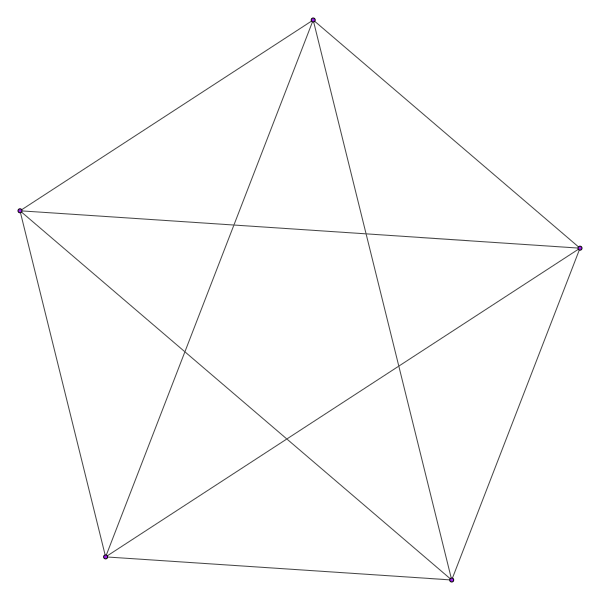

In [ ]:
graph3 = Graph([ # adjacency matrix
        [0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1],
        [1, 1, 1, 1, 0]
    ],[ # state vector
        [1],
        [0],
        [0],
        [1],
        [1]
    ])
    
graph3.plot()
RegularRule(4, 54265).jump(graph3, 10).plot()

## Examples

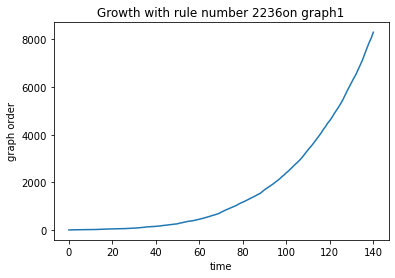

In [338]:
graph1 = Graph([ # adjacency matrix
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
    ],[ # state vector
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1]
    ])

rule_number = 2236
time_max = 140

# initialize the list that will hold the succesive graph orders with the first value
growth = [graph1.order()]

# loop that evolves the graph then adds the new graph order to the list
for i in range(time_max):
    graph1.evolve(RegularRule(3, rule_number))
    growth.append(graph1.order())

# growth plot
plt.plot(growth)
plt.title('Growth with rule number ' + str(rule_number) + 'on graph1')
plt.xlabel('time')
plt.ylabel('graph order')
plt.show()

graph1.plot()

In [339]:
graph1.order()

8298

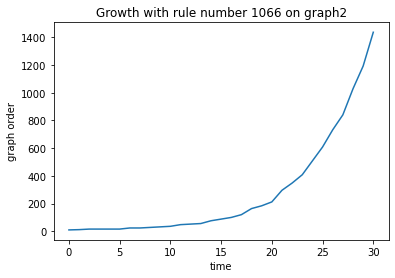

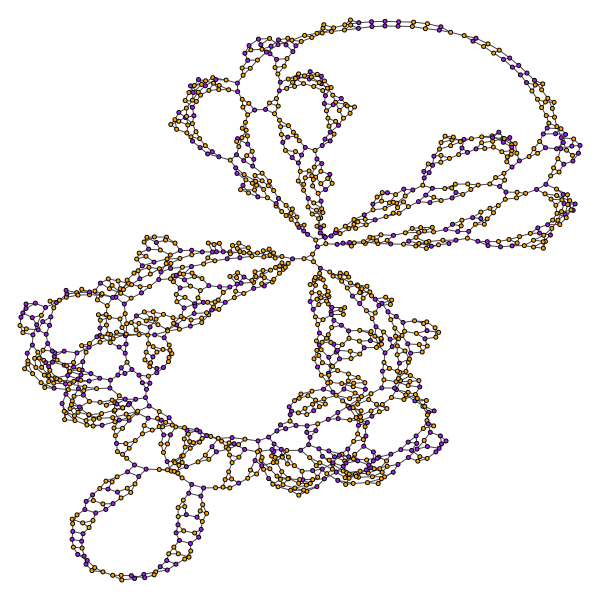

In [321]:
graph2 = Graph([ # adjacency matrix
        [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
    ],[ # state vector
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0]
    ])

rule_number = 1066
time_max = 30

# initialize the list that will hold the succesive graph orders with the first value
growth = [graph2.order()]

# loop that evolves the graph then adds the new graph order to the list
for i in range(time_max):
    graph2.evolve(RegularRule(3, rule_number))
    growth.append(graph2.order())

# growth plot
plt.plot(growth)
plt.title('Growth with rule number ' + str(rule_number) + ' on graph2')
plt.xlabel('time')
plt.ylabel('graph order')
plt.show()

graph2.plot()

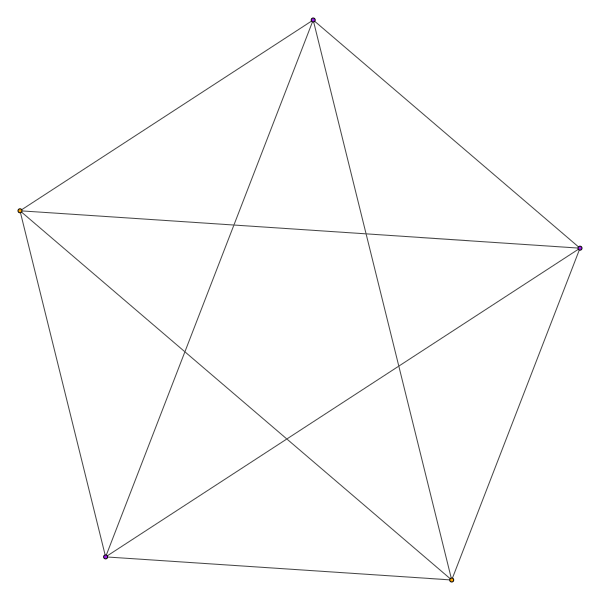

In [374]:
graph3 = Graph([ # adjacency matrix
        [0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1],
        [1, 1, 1, 1, 0]
    ],[ # state vector
        [1],
        [0],
        [0],
        [1],
        [1]
    ])
    
graph3.plot()

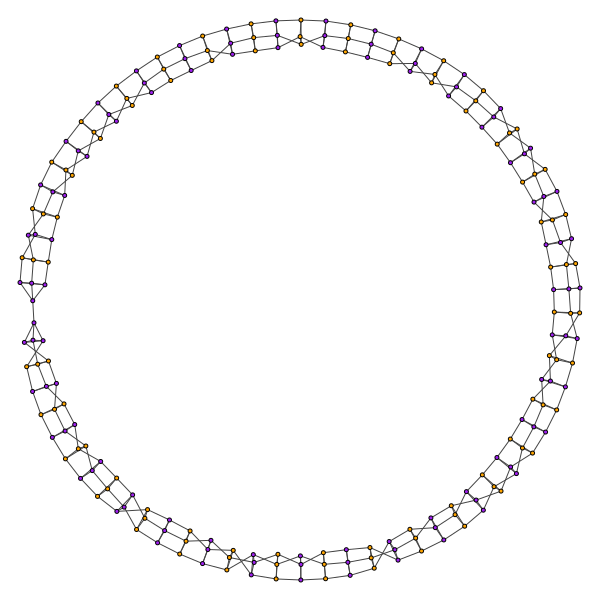

In [375]:
RegularRule(4, 8222).jump(graph3, 100).plot()